# Homework-2: 

`ANN training in Keras or Pytorch & Hyper-parameter tuning`

## Overview 

* Classification is one of the most common forms of supervised machine learning 
* In this homework we will explore "model tuning" for the case of a multi-class classification problem, as applied the MNIST data set
* `You can do this assignment in either Keras OR PyTorch` (or both), it is your choice.

## Submission 

* You need to upload TWO documents to Canvas when you are done
  * (1) A PDF (or HTML) of the completed form of the `HW-2.ipynb` document 
* The final uploaded version should NOT have any code-errors present 
* All outputs must be visible in the uploaded version, including code-cell outputs, images, graphs, etc

`IMPORTANT`: THERE ARE MANY WAYS TO DO THIS, SO FEEL FREE TO DEVIATE SLIGHTLY FROM THE EXACT DETAILS, BUT THE OVERALL RESULT AND FLOW SHOULD MATCH WHAT IS OUTLINED BELOW.

## HW-2.1: Data preparation

* Normalize the data as needed
* Partition data into training, validation, and test (i.e. leave one out CV)
  * One option to do this is to give these arrays global scope so they are seen inside the training function (so they don't need to be passed to functions)
* **Optional but recommended:** Create a K-fold cross validation data set, rather than just doing leave one out
* Do any other preprocessing you feel is needed

In [1]:
#loading package needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop,SGD
from tensorflow.keras.regularizers import l1, l2,l1_l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import GlorotUniform,RandomNormal
from sklearn.model_selection import KFold
import keras_tuner as kt
import seaborn as sns


importing packages needed for the task

In [2]:
(x_train_full, y_train_full), (x_test_full, y_test_full) = mnist.load_data()


x_train_full = x_train_full.reshape(x_train_full.shape[0], -1) / 255.0
x_test_full = x_test_full.reshape(x_test_full.shape[0], -1) / 255.0


x_data = np.vstack((x_train_full, x_test_full))
y_data = np.hstack((y_train_full, y_test_full))

x = x_data
y = y_data

y = to_categorical(y, num_classes=10)

kf = KFold(n_splits=3, shuffle=True, random_state=42)

folds = []
for train_index, test_index in kf.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    val_size = len(x_train) // 2
    x_val, y_val = x_train[:val_size], y_train[:val_size]
    x_train, y_train = x_train[val_size:], y_train[val_size:]

    folds.append((x_train, y_train, x_val, y_val, x_test, y_test))


first loading mnist data, then flatten and normalizing data
as recommended, using kfold with 3 folds for the data


## HW-2.2: Generalized model

* Create a `General` model function (or class) that takes hyper-parameters and evaluates the model
  * The function should work with a set of hyper parameters than can be easily be controlled and varied by the user (for later parameter tuning)
  * This should work for the training, test, and validation set 
* Feel free to recycle code from the lab assignments and demo's  
* Use the deep learning best practices that we discussed in class. 
* Document what is going on in the code, as needed, with narrative markdown text between cells.

define class NN1 for generalized model

first part of function is initialization function, with shape of input, number of class(in this dataset there are ten), number of nuerons in each hidden layer(manually set), activation as relu, optimizer ADAM,
loss function as categorical crossentropy(multi classification), batch size 32, epoch as 10. 

m1 is nueral network model two dense layer and output layer, two dense layer uses relu as activation and number of nuerons and input shape are from initialization for output layer, activation function is softmax function(multi classification),and num classses represents the classses(in this dataset there are 10 classes)

next, compile model with ADAM as optimizer, loss as categorical crossentropy. 
next, train model, inputting training set and validation set in validation data.epochs, batch size are from initialization

finally evaluates model, using evaluate(), printing test accuracy


In [3]:
class NN1:
    def __init__(self, input_shape, num_classes=10, hidden_units=128, activation='relu', 
                 optimizer='adam', loss='categorical_crossentropy', batch_size=32, epochs=10):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.hidden_units = hidden_units
        self.activation = activation
        self.optimizer = optimizer
        self.loss = loss
        self.batch_size = batch_size
        self.epochs = epochs
        self.model = self.m1()

    def m1(self):
        model1 = Sequential([
            Dense(self.hidden_units, activation=self.activation, input_shape=(self.input_shape,)),
            Dense(self.hidden_units, activation=self.activation),
            Dense(self.num_classes, activation='softmax')])
        model1.compile(optimizer=self.optimizer, loss=self.loss, metrics=['accuracy'])
        return model1
    
    def train(self, x_train, y_train, x_val, y_val):
        history = self.model.fit(x_train, y_train, validation_data=(x_val, y_val),
                                 epochs=self.epochs, batch_size=self.batch_size, verbose=1)
        return history
    
    def evaluate(self, x_test, y_test):
        test_loss, test_acc = self.model.evaluate(x_test, y_test, verbose=0)
        print(f"\ntest accuracy: {test_acc:.4f}")
        return test_acc

model = NN1(input_shape=x_train.shape[1], hidden_units=128, epochs=10, batch_size=64)
history = model.train(x_train, y_train, x_val, y_val)
test_accuracy = model.evaluate(x_test, y_test)


Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7868 - loss: 0.7211 - val_accuracy: 0.9386 - val_loss: 0.2075
Epoch 2/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9507 - loss: 0.1631 - val_accuracy: 0.9457 - val_loss: 0.1796
Epoch 3/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9675 - loss: 0.1097 - val_accuracy: 0.9568 - val_loss: 0.1373
Epoch 4/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9747 - loss: 0.0835 - val_accuracy: 0.9585 - val_loss: 0.1390
Epoch 5/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9836 - loss: 0.0576 - val_accuracy: 0.9643 - val_loss: 0.1217
Epoch 6/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9868 - loss: 0.0428 - val_accuracy: 0.9598 - val_loss: 0.1390
Epoch 7/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9890 - loss: 0.0323 - val_accuracy: 0.9639 - val_loss: 0.1358
Epoch 8/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9912 - loss: 0.0262 - val_accuracy: 0.9672 - val_

## HW-2.3: Model training function

* You can do this in either a function (or python class), or however you think is best. 
* **Create a training function** (or class) that takes hyper-parameter choices and trains the model
  * If you are doing "leave one out", your training function only needs to do one training per hyper-parameter choice
  * If you are doing K-fold cross validation, you should train the model K times for each hyper-parameter choice, and report the average result cross the training runs at the end (this is technically a better practice but requires more computation). 
  * Use a dense feed forward ANN model, with the correct output layer activation, and correct loss function
  * `You MUST use early stopping` inside the function, otherwise it defeats the point
  * **Have at least the following hyper-parameters as inputs to this function** 
    * L1 regularization constant, L2 regularization constant, dropout rate 
    * Learning rate
    * Weight Initialization: Fully random vs Xavier Weight Initialization
    * Hidden layer activation function choice (use relu, sigmoid, or tanh)
    * Number and size of ANN hidden layers 
    * Optimizer choice, have at least three included (Adam, SGD, or RmsProp)
    * You can wrap all of the hyper-parameter arguments into a dictionary, or do it however you want  
  * **Visualization**
    * Include a boolean parameter as a function input that controls whether visualization is created or not
    * If `true`, Monitor training and validation throughout training by plotting
    * Report a confusion matrix 
  * Return the final training and validation error (averaged if using K-fold)
    * again, you must use early stopping to report the best training/validation loss without over-fitting
* Depending how you do this, it can be a lot of computation, start small and scale up and consider using Co-lab 
  

create class name M1.
init function is a initialization for the process with input shape, number of classes, hyperparameters(dealt with later),kfold splits(set as two for efficency),and visualization as true.

1. fucntion m2 is a nueral network model. 
inside a function, first part is checking hyper parameter. 
first process of this is weight initialization. if weight initialization is xavier , then use glorouniform function, if not use random normal function. 
next is hidden payer. in this part, add hidden layer dynamically and use l1 and l2 regulariation, also uses dropout rate. for output layer activation function uses softmax function. 

next process is choosing optimizers. for optimizers(in this case), there are three optimizers, ADAM, SGD and rmsprop, using learning rate(will be adjusted later)

next is compiling model, loss function is categorical crossentropy(multi classification), using optimizers that has been set previously. 

2. next part is training model. here instead of LOOCV, using kfold with 2 splits for train and evaluate model (just choose this number for efficency). 

first part of code is doing kfolds, like did in data processing part. after that add early stopping with count five, if validation loss doesn't improve for five patience, it stops. then proceed for fitting model for training model, and evaluate the model by printing validation loss and training loss. 

3. final part is plotting curve and confusion matrix. first function for visualization is plotting curve for training and validation loss. for confusion matrix, since y has been one hot coded, it needs extra step, converting one hot coded labels to  predicted probabilities. and then create confusion matrix, with heatmap




In [4]:
class M1:
    def __init__(self, input_shape, num_classes, hyperparam, n_splits=2, visualize=True):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.hyperparams = hyperparam
        self.n_splits = n_splits
        self.visualize = visualize
        self.histories = []
        self.y_preds = []
        self.y_trues = []

    def m2(self):
       
        model = Sequential()

        if self.hyperparams['weight_init'] == 'xavier':
         initializer = GlorotUniform()  
        else:
           initializer=  RandomNormal()

        for units in self.hyperparams['hidden_layer']:
            model.add(Dense(units, activation=self.hyperparams['activation'],
                            kernel_regularizer=l1_l2(self.hyperparams['l1'], self.hyperparams['l2']),
                            kernel_initializer=initializer))
            model.add(Dropout(self.hyperparams['dropout']))

        
        model.add(Dense(self.num_classes, activation='softmax'))

        
        optimizer_choices = {
            'adam': Adam(learning_rate=self.hyperparams['learning_rate']),
            'sgd': SGD(learning_rate=self.hyperparams['learning_rate']),
            'rmsprop': RMSprop(learning_rate=self.hyperparams['learning_rate'])
        }
        optimizer = optimizer_choices[self.hyperparams['optimizer']]

        
        model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])

        return model

    def train(self, x, y):
       
        kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        hist = []
        Test_accuracy, Val_loss, Train_loss = [], [], []
        
        fold = 1
        Y_pred, Y_actual = [], []

        for train_idx, test_idx in kf.split(x):
            print(f"\nTraining Fold {fold}...\n")
        
            
            x_train, x_test = x[train_idx], x[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            
            val_size = int(len(x_train) * 0.2)
            x_val, y_val = x_train[:val_size], y_train[:val_size]
            x_train, y_train = x_train[val_size:], y_train[val_size:]

            
            model = self.m2()

            
            early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

            
            history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                                epochs=self.hyperparams['epochs'],
                                batch_size=self.hyperparams['batch_size'],
                                verbose=1, callbacks=[early_stop])
            hist.append(history)

            
            test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
            val_loss = min(history.history['val_loss']) 
            train_loss = min(history.history['loss'])  

            Test_accuracy.append(test_acc)
            Val_loss.append(val_loss)
            Train_loss.append(train_loss)

            print(f"Fold {fold} - Test Accuracy: {test_acc:.4f}")

            
            y_pred = np.argmax(model.predict(x_test), axis=1)
            Y_pred.extend(y_pred)
            Y_actual.extend(y_test)

            fold += 1
    
        
        avg_train_loss = np.mean(Train_loss)
        avg_val_loss = np.mean(Val_loss)
        avg_test_acc = np.mean(Test_accuracy)

        
        if self.visualize:
            self.plot_training_curves(hist)
            self.plot_confusion_matrix(Y_actual, Y_pred)

        return avg_train_loss, avg_val_loss, avg_test_acc

    def plot_training_curves(self, histories):
       
        for i, history in enumerate(histories):
         plt.plot(history.history['loss'], label=f'Train Fold {i+1}')
         plt.plot(history.history['val_loss'], label=f'Val Fold {i+1}', linestyle='dashed')
         plt.title('Training & Validation Loss')
         plt.xlabel('Epochs')
         plt.ylabel('Loss')
         plt.legend()
         plt.show()

    
    
    def plot_confusion_matrix(self, y_true, y_pred):
     y_true = np.array(y_true)
     y_pred = np.array(y_pred)

     if y_true.ndim > 1: 
        y_true = np.argmax(y_true, axis=1)

     if y_pred.ndim > 1:  
        y_pred = np.argmax(y_pred, axis=1)

     cm = confusion_matrix(y_true, y_pred)
     plt.figure(figsize=(8, 6))
     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(self.num_classes), yticklabels=range(self.num_classes))
     plt.xlabel('Predicted Label')
     plt.ylabel('True Label')
     plt.title('Confusion Matrix')
     plt.show()


this part is utilizing class M1, hyperparameters are set manually for this time. 


Training Fold 1...

Epoch 1/3
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7599 - loss: 7.5909 - val_accuracy: 0.8966 - val_loss: 1.1450
Epoch 2/3
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8654 - loss: 1.1430 - val_accuracy: 0.9089 - val_loss: 0.8932
Epoch 3/3
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8780 - loss: 0.9779 - val_accuracy: 0.9166 - val_loss: 0.8230
Fold 1 - Test Accuracy: 0.9141
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step

Training Fold 2...

Epoch 1/3
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7547 - loss: 7.6574 - val_accuracy: 0.8951 - val_loss: 1.1503
Epoch 2/3
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8624 - loss: 1.1639 - val_accuracy: 0.9120 - val_loss: 0.8927
Epoch 3/3
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8726 - loss: 0.9974 - val_accuracy: 0.9223 - val_loss: 0.8105
Fold 2 - Test Accuracy: 0.9206
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step


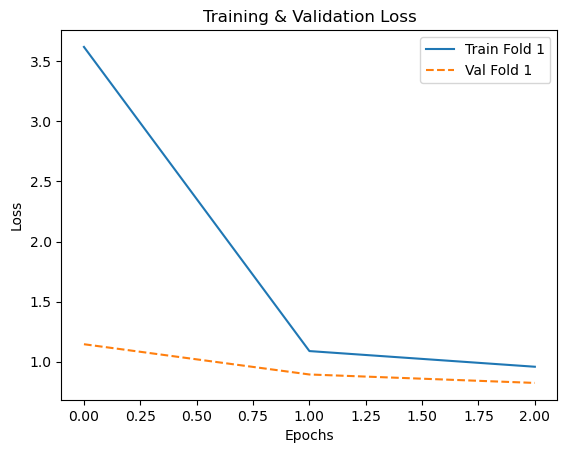

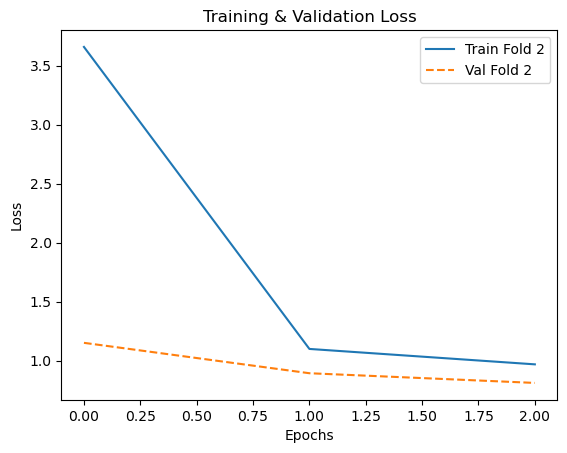

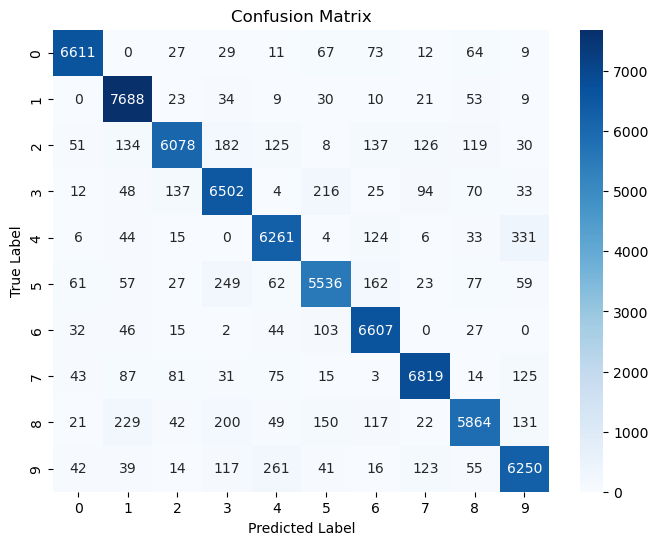


Final Results: Avg Train Loss = 0.9628, Avg Val Loss = 0.8168, Avg Test Accuracy = 0.9174


In [5]:
hyperparams = {
    'hidden_layer': [512, 256],   
    'activation': 'relu',
    'optimizer': 'adam',
    'learning_rate': 0.001,
    'l1': 0.001,
    'l2': 0.001,
    'dropout': 0.3,
    'epochs': 3,
    'batch_size': 64,
    'weight_init': 'xavier'
}

model = M1(input_shape=x.shape[1], num_classes =10, hyperparam=hyperparams, n_splits=2, visualize=True)
avg_train_loss, avg_val_loss, avg_test_acc = model.train(x, y)
print(f"\nFinal Results: Avg Train Loss = {avg_train_loss:.4f}, "
              f"Avg Val Loss = {avg_val_loss:.4f}, Avg Test Accuracy = {avg_test_acc:.4f}")

## HW-2.4: Hyper-parameter tuning

* Keep detailed records of hyper-parameter choices and associated training & validation errors
* Think critically and visualize the results of the search as needed

* **Do each of these in a different sub-section of your notebook**
  
* **Explore hyper-parameter choice-0**
  * for hidden activation=Relu, hidden layers = [32,32], optimizer=adam
  * Vary the learning rate via a grid search pattern
  * Plot training and validation error as a function of the learning rate
  * Repeat this exercise for both random and Xavier weight initialization 

* **Explore hyper-parameter choice-1**
  * for hidden activation=relu, hidden layers = [64,64], optimizer=adam
  * Vary L1 and L2 in a 10x10 grid search (without dropout) 
  * Plot validation and training error as a function of L1 and L2 regularization in a 2D heatmap 
  * Plot the ratio (or difference) of validation to training error as a function of L1 and L2 regularization in a 2D heatmap 

* **Explore hyper-parameter choice-2**
  * for hidden activation=sigmoid, hidden layers = [96,96,96], optimizer=**rmsprop**
  * Vary drop-out parameter in a 1x10 grid search (without L1 or L2 regularization) 
  * Plot training and validation error as a function of dropout rate  
  * Plot the ratio (or difference) of validation to training error as a function of dropout rate  

* **Explore hyper-parameter choice-3:**
  * for hidden activation=relu, hidden layers = [96,96,96], optimizer=**adam**
  * Vary drop-out parameter in a 1x10 grid search (without L1 or L2 regularization) 
  * Plot training and validation as a function of dropout rate  
  * Plot the ratio (or difference) of validation to training error as a function of dropout rate  

* `Optional` Systematically search for the best regularization parameters choice (3D search) using random search algorithm 
  * (https://en.wikipedia.org/wiki/Random_search)[https://en.wikipedia.org/wiki/Random_search]
  * Try to see how deep you can get the ANN (max hidden layers) without suffering from the vanishing gradient effect  
  
* `Final fit`
  * At the very end, select a best fit model and report, training, validation, and test errors at the very end
  * Make sure your "plotting variable=True" when for the final training
  

train_model function is a intiralized function for hyper parameter tuning process, it uses M1 classes in the previous step, adding early stopping, and prints training,validation loss and average test accuracy

In [6]:

def train_model(hyperparams, title):
    
    model = M1(input_shape=x.shape[1], num_classes=10, hyperparam=hyperparams, visualize=False)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    avg_train_loss, avg_val_loss, avg_test_acc = model.train(x,y)
    print(f"{title} - train Loss: {avg_train_loss}, val Loss: {avg_val_loss},avg_test_acc:{avg_test_acc}")
    return avg_train_loss, avg_val_loss


## choice 0

set learning rate grid as 0.0001,0.0005,0.001
function learning rate tries to check learning rate for different weight initialization(xavier,random )

inside the loop, hyper parameters are using the condition of this choice,and after training,
it stores training loss and valudation loss.

next is plitting for training, vaildation loss and learning rate for each weight initialization




learning rate for weight init: random

Training Fold 1...

Epoch 1/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 793us/step - accuracy: 0.3416 - loss: 2.1032 - val_accuracy: 0.7640 - val_loss: 1.1601
Epoch 2/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - accuracy: 0.7868 - loss: 0.9734 - val_accuracy: 0.8520 - val_loss: 0.6212
Epoch 3/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - accuracy: 0.8593 - loss: 0.5735 - val_accuracy: 0.8743 - val_loss: 0.4744
Epoch 4/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - accuracy: 0.8780 - loss: 0.4508 - val_accuracy: 0.8884 - val_loss: 0.4100
Epoch 5/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - accuracy: 0.8905 - loss: 0.3916 - val_accuracy: 0.8946 - val_loss: 0.3755
Fold 1 - Test Accuracy: 0.8939
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step

Training Fold 2...

Epoch 1/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step - accuracy: 0.3553 - loss: 2.1109 - val_accuracy: 0.7693 - val_loss: 1.1417
Epoch 2/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - accuracy: 0.80

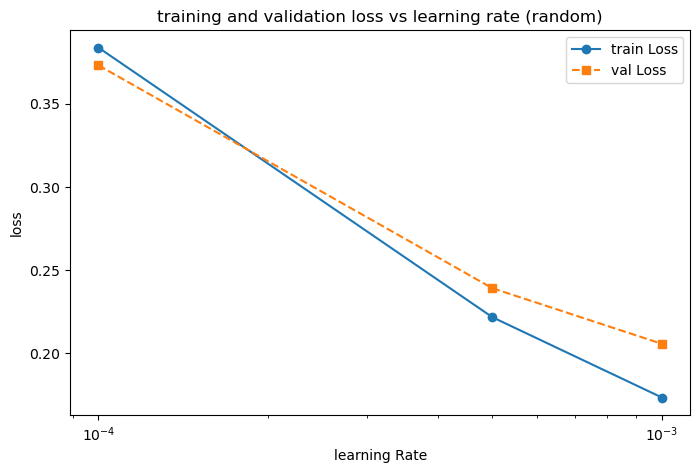


learning rate for weight init: xavier

Training Fold 1...

Epoch 1/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 714us/step - accuracy: 0.3205 - loss: 2.0252 - val_accuracy: 0.8007 - val_loss: 0.9698
Epoch 2/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - accuracy: 0.8335 - loss: 0.7981 - val_accuracy: 0.8630 - val_loss: 0.5416
Epoch 3/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - accuracy: 0.8724 - loss: 0.4990 - val_accuracy: 0.8821 - val_loss: 0.4385
Epoch 4/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - accuracy: 0.8896 - loss: 0.4136 - val_accuracy: 0.8910 - val_loss: 0.3920
Epoch 5/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - accuracy: 0.8994 - loss: 0.3640 - val_accuracy: 0.8967 - val_loss: 0.3643
Fold 1 - Test Accuracy: 0.9001
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step

Training Fold 2...

Epoch 1/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step - accuracy: 0.3668 - loss: 1.9892 - val_accuracy: 0.7776 - val_loss: 0.9554
Epoch 2/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - accuracy: 0.80

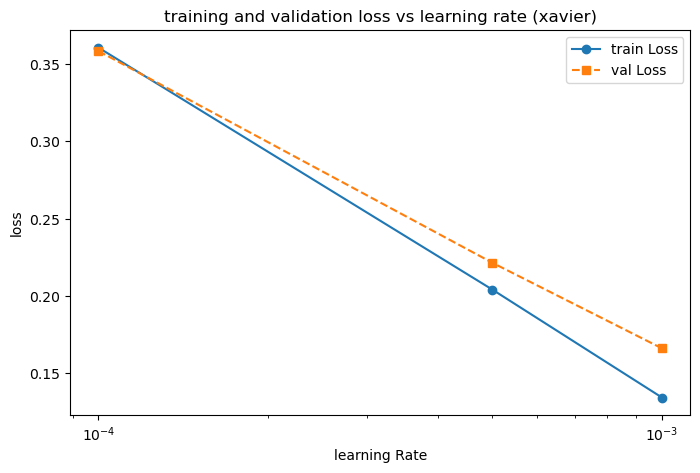

In [7]:
learning_rates = [0.0001, 0.0005, 0.001]

def learn_rate(weight_init):
    print(f"\nlearning rate for weight init: {weight_init}")
    train_losses, val_losses = [], []

    for lr in learning_rates:
        hyperparams = {'hidden_layer': [32, 32], 'activation': 'relu', 'optimizer': 'adam',
                       'learning_rate': lr, 'dropout': 0.0, 'l1': 0.0, 'l2': 0.0, 'weight_init': weight_init, 'epochs': 5
                       ,'batch_size':64}
        train_loss, val_loss = train_model(hyperparams, f"LR={lr}")
        train_losses.append(train_loss)
        val_losses.append(val_loss)

   
    plt.figure(figsize=(8, 5))
    plt.plot(learning_rates, train_losses, label="train Loss", marker='o')
    plt.plot(learning_rates, val_losses, label="val Loss", linestyle='dashed', marker='s')
    plt.xscale('log')
    plt.xlabel("learning Rate")
    plt.ylabel("loss")
    plt.title(f"training and validation loss vs learning rate ({weight_init})")
    plt.legend()
    plt.show()

learn_rate('random')
learn_rate('xavier')

## choice 1

for l1 and l2 regularization value, use log value with ten values
also, inside the loop, hyper parameters are used based on the condition for this choice
as same as previous hyper parmeter choice, this also trains model and get training, validation loss.
but additionally this choice get ratio for l1 and l2 regularization, to prevent 0, add very small number to denominator(just in case)

In [8]:
l1_l2_values = np.logspace(-5,-2, 10)

l1_l2_train_losses = np.zeros((10,10))
l1_l2_val_losses = np.zeros((10,10))

for i, l1 in enumerate(l1_l2_values):
    for j, l2 in enumerate(l1_l2_values):
        hyperparams = {'hidden_layer': [64, 64], 'activation': 'relu', 'optimizer': 'adam',
                       'learning_rate': 0.001, 'dropout': 0.0, 'l1': l1, 'l2': l2, 'weight_init': 'xavier', 'epochs': 3,
                       'batch_size':64}
        train_loss, val_loss = train_model(hyperparams, f"L1={l1}, L2={l2}")
        l1_l2_train_losses[i, j] = train_loss
        l1_l2_val_losses[i, j] = val_loss


ratio1 = l1_l2_val_losses / (l1_l2_train_losses + 1e-8)  



Training Fold 1...

Epoch 1/3
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 917us/step - accuracy: 0.7737 - loss: 0.8128 - val_accuracy: 0.9260 - val_loss: 0.2772
Epoch 2/3
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - accuracy: 0.9376 - loss: 0.2332 - val_accuracy: 0.9416 - val_loss: 0.2199
Epoch 3/3
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - accuracy: 0.9577 - loss: 0.1713 - val_accuracy: 0.9544 - val_loss: 0.1766
Fold 1 - Test Accuracy: 0.9539
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step

Training Fold 2...

Epoch 1/3
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 855us/step - accuracy: 0.7706 - loss: 0.8524 - val_accuracy: 0.9287 - val_loss: 0.2685
Epoch 2/3
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - accuracy: 0.9416 - loss: 0.2202 - val_accuracy: 0.9464 - val_loss: 0.2105
Epoch 3/3
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - accuracy: 0.9586 - loss: 0.1692 - val_accuracy: 0.9530 - val_loss: 0.1848
Fold 2 - Test Accuracy: 0.9531
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
L1=1e-05, L2=1e-05 - train Loss:

this part plots the result for previous step(choice1)
first heatmap is for training loss, second heatmap is for validation loss and last heatmap is for ratio

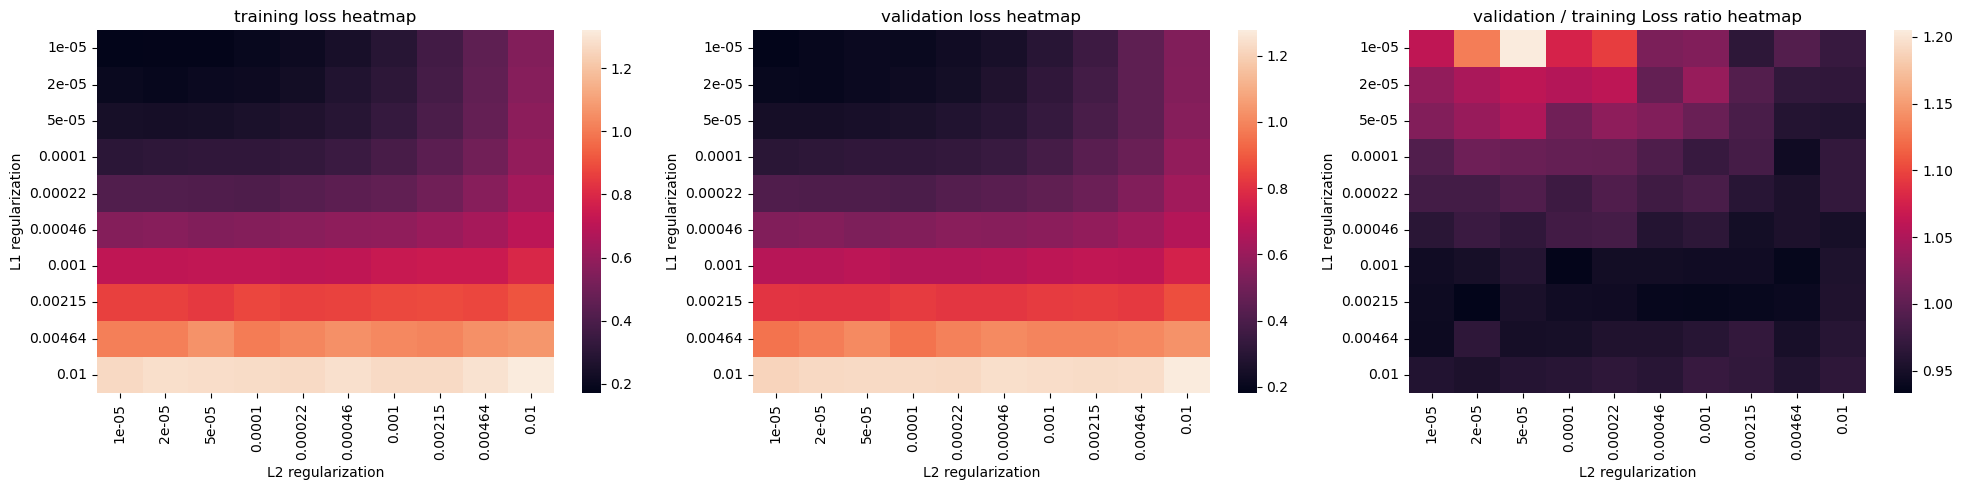

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.heatmap(l1_l2_train_losses, annot=False, xticklabels=np.round(l1_l2_values, 5), 
            yticklabels=np.round(l1_l2_values, 5), ax=ax[0])
ax[0].set_title("training loss heatmap")
ax[0].set_xlabel("L2 regularization")
ax[0].set_ylabel("L1 regularization")

sns.heatmap(l1_l2_val_losses, annot=False, xticklabels=np.round(l1_l2_values, 5), 
            yticklabels=np.round(l1_l2_values, 5), ax=ax[1])
ax[1].set_title("validation loss heatmap")
ax[1].set_xlabel("L2 regularization")
ax[1].set_ylabel("L1 regularization")

sns.heatmap(ratio1, annot=False, xticklabels=np.round(l1_l2_values, 5), 
            yticklabels=np.round(l1_l2_values, 5), ax=ax[2])
ax[2].set_title("validation / training Loss ratio heatmap")
ax[2].set_xlabel("L2 regularization")
ax[2].set_ylabel("L1 regularization")

plt.tight_layout()
plt.show()

## choice 2

this part explores drop rate, first create 10 dropout rate. and loop it through, with other hyperparemters are from the condtion for this choice. next print training, validation loss , and ratio(add very small number to avoid zero). 

from this result, create two plots, first plot is training and validation loss for dropout rate and second plot is ratio of validation and training losss for drop out rate 


Training Fold 1...

Epoch 1/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7675 - loss: 0.7685 - val_accuracy: 0.9234 - val_loss: 0.2623
Epoch 2/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.9409 - loss: 0.1969 - val_accuracy: 0.9510 - val_loss: 0.1645
Epoch 3/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - accuracy: 0.9629 - loss: 0.1198 - val_accuracy: 0.9574 - val_loss: 0.1438
Epoch 4/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.9693 - loss: 0.0981 - val_accuracy: 0.9621 - val_loss: 0.1289
Epoch 5/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - accuracy: 0.9757 - loss: 0.0785 - val_accuracy: 0.9677 - val_loss: 0.1115
Fold 1 - Test Accuracy: 0.9661
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step

Training Fold 2...

Epoch 1/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7632 - loss: 0.7720 - val_accuracy: 0.9296 - val_loss: 0.2385
Epoch 2/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - accuracy: 0.9392 - loss: 0.1939 - val_accuracy: 0.9520 - 

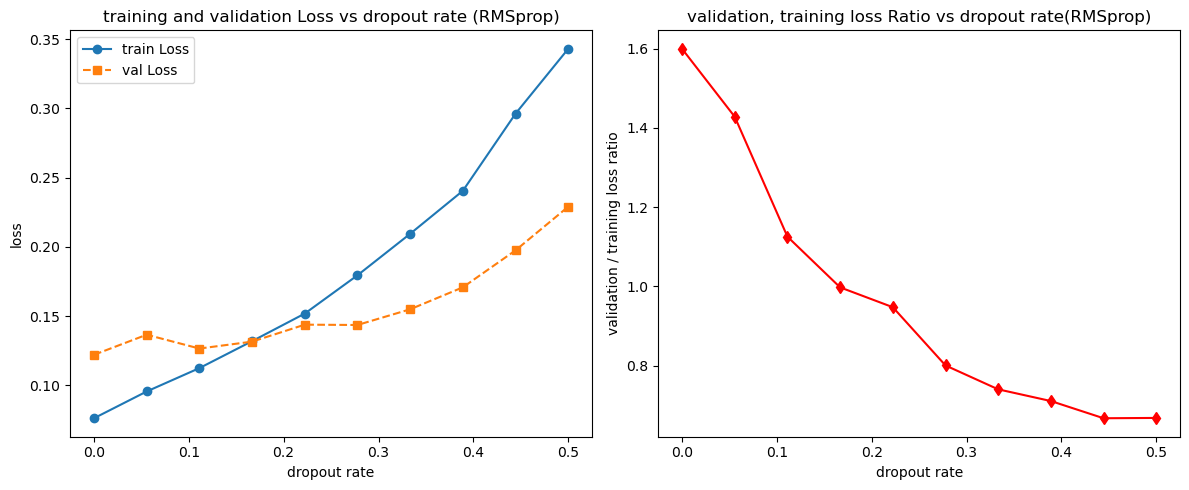

In [10]:
train_losses2, val_losses2 = [], []
dropout_rates2 = np.linspace(0.0, 0.5, 10)
for dropout in dropout_rates2:
    hyperparams = {'hidden_layer': [96, 96, 96], 'activation': 'relu', 'optimizer': 'rmsprop',
                   'learning_rate': 0.001, 'dropout': dropout, 'l1': 0.0, 'l2': 0.0, 'weight_init': 'random', 'epochs': 5,
                   'batch_size':64}
    train_loss, val_loss = train_model(hyperparams, f"Dropout={dropout}")
    train_losses2.append(train_loss)
    val_losses2.append(val_loss)

error_ratio2 = np.array(val_losses2) / (np.array(train_losses2) + 1e-8)  # Avoid division by zero

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(dropout_rates2, train_losses2, label="train Loss", marker='o')
ax[0].plot(dropout_rates2, val_losses2, label="val Loss", linestyle='dashed', marker='s')
ax[0].set_xlabel("dropout rate")
ax[0].set_ylabel("loss")
ax[0].set_title("training and validation Loss vs dropout rate (RMSprop)")
ax[0].legend()

ax[1].plot(dropout_rates2, error_ratio2, marker='d', color='r')
ax[1].set_xlabel("dropout rate")
ax[1].set_ylabel("validation / training loss ratio")
ax[1].set_title("validation, training loss Ratio vs dropout rate(RMSprop)")

plt.tight_layout()
plt.show()

## choice 3

this part explores drop rate, first create 10 dropout rate. and loop it through, with other hyperparemters are from the condtion for this choice. next print training, validation loss , and ratio(add very small number to avoid zero). however, compare to choice 2 this one use ADAM as optimizer.

from this result, create two plots, first plot is training and validation loss for dropout rate and second plot is ratio of validation and training losss for drop out rate 


Training Fold 1...

Epoch 1/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7456 - loss: 0.8249 - val_accuracy: 0.9243 - val_loss: 0.2583
Epoch 2/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - accuracy: 0.9420 - loss: 0.1940 - val_accuracy: 0.9419 - val_loss: 0.1912
Epoch 3/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.9582 - loss: 0.1377 - val_accuracy: 0.9583 - val_loss: 0.1424
Epoch 4/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - accuracy: 0.9692 - loss: 0.0968 - val_accuracy: 0.9616 - val_loss: 0.1287
Epoch 5/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - accuracy: 0.9775 - loss: 0.0728 - val_accuracy: 0.9627 - val_loss: 0.1220
Fold 1 - Test Accuracy: 0.9614
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step

Training Fold 2...

Epoch 1/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7579 - loss: 0.8178 - val_accuracy: 0.9316 - val_loss: 0.2305
Epoch 2/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.9428 - loss: 0.1915 - val_accuracy: 0.9506 - 

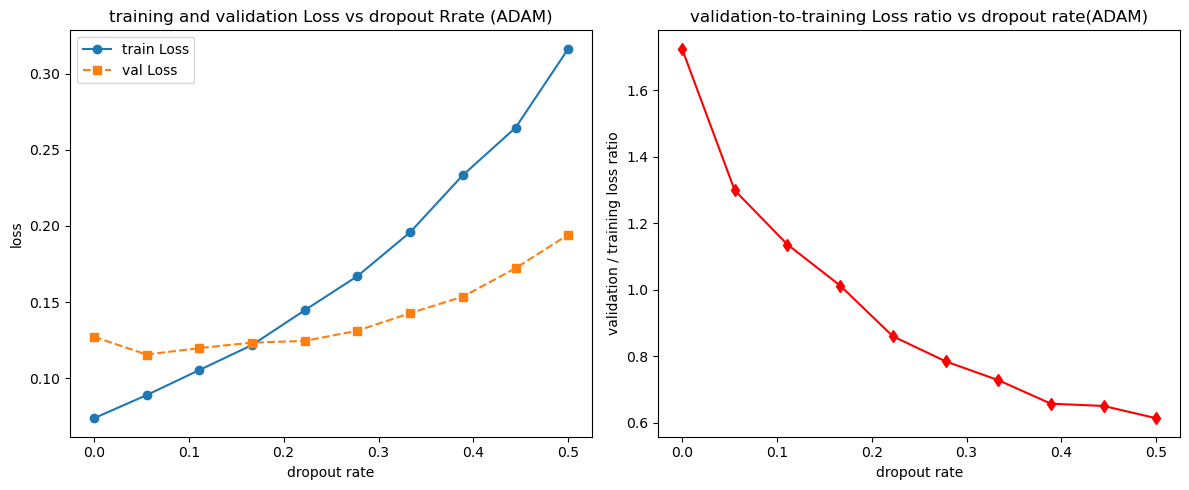

In [11]:
train_losses3, val_losses3 = [], []
dropout_rates3 = np.linspace(0.0, 0.5, 10)
for dropout in dropout_rates3:
    hyperparams = {'hidden_layer': [96, 96, 96], 'activation': 'relu', 'optimizer': 'adam',
                   'learning_rate': 0.001, 'dropout': dropout, 'l1': 0.0, 'l2': 0.0, 'weight_init': 'random', 'epochs': 5,
                   'batch_size':64}
    train_loss, val_loss = train_model(hyperparams, f"Dropout={dropout}")
    train_losses3.append(train_loss)
    val_losses3.append(val_loss)

error_ratio3 = np.array(val_losses3) / (np.array(train_losses3) + 1e-8)  

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(dropout_rates3, train_losses3, label="train Loss", marker='o')
ax[0].plot(dropout_rates3, val_losses3, label="val Loss", linestyle='dashed', marker='s')
ax[0].set_xlabel("dropout rate")
ax[0].set_ylabel("loss")
ax[0].set_title("training and validation Loss vs dropout Rrate (ADAM)")
ax[0].legend()

ax[1].plot(dropout_rates3, error_ratio3, marker='d', color='r')
ax[1].set_xlabel("dropout rate")
ax[1].set_ylabel("validation / training loss ratio")
ax[1].set_title("validation-to-training Loss ratio vs dropout rate(ADAM)")

plt.tight_layout()
plt.show()

# Bonus assignment 

`+5 bonus points`

`You DO NOT need to do this if you don't want to`

* Once the data is collected, this HW should be quite easy, since most of the code can be recycled from the labs & textbook. 

* Do this in a file called `bonus.ipynb`, have it save its results to a folder "data"

`Data collection`

* Develope a text based classification data-set:
* Use the Wikipedia API to search for articles to generate the data-set
* Select a set of highly different topics (i.e. labels), for example,
  * multi-class case: y=(pizza, oak_trees, basketball, ... , etc)=(0,1,2, ... , N-1)
  * You don't have to use these, you can use whatever labels you want
  * `Have AT LEAST 10 labels.` 
  * The more different the topics, the easier the classification task should be 
* Search for Wikipedia pages about these topics and harvest the text from the pages. 
* Do some basic text cleaning as needed. 
  * e.g. use the NLTK sentence tokenizer to break the text into sentences. 
  * Then form chunks of text that are five sentences long as your "inputs".
* The "label" for these chunks will be the search label used to find the text. 
* The data set will not be perfect. 
  * There will be chunks of text that are not related to the topic (i.e. noise). 
  * However that is just something we have to live with.
* **Important**: Always start small when writing & debugging THEN scale up. 
* The more chunks of text you have the better.
  * Save the text and labels to the same format used by the textbook, that way you can recycle your lab code seamlessly. 
* `Optional practice`: You can also "tag" each chunk of text with an associated "compound" sentiment score computed using the NLTK sentiment analysis. From this you can train a regression model in part-2. This is somewhat silly, and is just for educational purposes, since your using a model output to train another model. 

`Model training`

* Repeat the model training and hyper-parameter tuning exercise for MNIST, but with your text.